In [128]:
# Cell 1: Setup and Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.cuda.amp  # For mixed precision training
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
import torch.multiprocessing as mp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import gc  # For garbage collection

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set the start method to 'spawn'
if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)

CUDA available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


# Introduction

In the following exploratory data analysis, the original [pdb-secondary-structure](https://www.kaggle.com/datasets/alfrandom/protein-secondary-structure) dataset is compared to the updated datasets in [Protein Secondary Structure - 2022](https://www.kaggle.com/datasets/kirkdco/protein-secondary-structure-2022) dataset.

In [129]:
# Load the various datasets

# original dataset from 2018
ss_2018 = pd.read_csv('/kaggle/input/protein-secondary-structure/2018-06-06-pdb-intersect-pisces.csv')

# these datasets were found to be only updated through mid-2020 - variables names were changed to reflect this
# updated data with 25% identity and 2.0 Angstrom cutoffs 
ss_2020_25_20 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc25_r2.0.csv')

# updated data with 25% identity and 2.5 Angstrom cutoffs 
ss_2020_25_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc25_r2.5.csv')

# updated data with 30% identity and 2.5 Angstrom cutoffs 
ss_2020_30_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-08-06-pdb-intersect-pisces_pc30_r2.5.csv')

# update datasets through end of 2022
ss_2022_25_20 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc25_r2.0.csv')
ss_2022_25_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc25_r2.5.csv')
ss_2022_30_25 = pd.read_csv('/kaggle/input/protein-secondary-structure-2022/2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv')

### Number of Sequences

When the updates were made, the culling file used had changed to only have sequences of length 40 and higher, where the original culling file used had sequences of length 20 and higher.  This reduced the overall number of sequences available.  To account for this and provide more sequences and secondary structures the percent identity and resolution cutoffs were relaxed.  The quality of the data should not be affected and the number of sequences increased substantially

In [130]:
tbl_data = [['ss_2018', '25%', '2.0 Angstrom', len(ss_2018)],
            ['ss_2020_25_20', '25%', '2.0 Angstrom', len(ss_2020_25_20)],
            ['ss_2020_25_25', '25%', '2.5 Angstrom', len(ss_2020_25_25)],
            ['ss_2020_30_20', '30%', '2.5 Angstrom', len(ss_2020_30_25)],
            ['ss_2022_25_20', '25%', '2.0 Angstrom', len(ss_2022_25_20)],
            ['ss_2022_25_25', '25%', '2.5 Angstrom', len(ss_2022_25_25)],
            ['ss_2022_30_20', '30%', '2.5 Angstrom', len(ss_2022_30_25)]]
pd.DataFrame(tbl_data, columns = ['Dataset', 'Percent Identity Cutoff', 
                                  'Resolution Cutoff', 'Number of Sequences'])

,Dataset,Percent Identity Cutoff,Resolution Cutoff,Number of Sequences
0,ss_2018,25%,2.0 Angstrom,9078
1,ss_2020_25_20,25%,2.0 Angstrom,7320
2,ss_2020_25_25,25%,2.5 Angstrom,9646
3,ss_2020_30_20,30%,2.5 Angstrom,13406
4,ss_2022_25_20,25%,2.0 Angstrom,8313
5,ss_2022_25_25,25%,2.5 Angstrom,10931
6,ss_2022_30_20,30%,2.5 Angstrom,15079


### Distribution of Sequence Lengths

As mentioned above, when keeping the same cutoff criteria as the original dataset from 2018, the updated file had fewer overall sequences and was slightly shifted toward longer sequences.  Adjusting the cutoff criteria allowed for expansion of the dataset to ~47% more overall sequences.  Also, sequences within the 50 to 500 amino acid range are substantially increased in the ss_2022_30_25 dataset which had the most permissive cutoff criteria of 30% sequence identity and 2.5 Angstrom resolution (bottom-left).

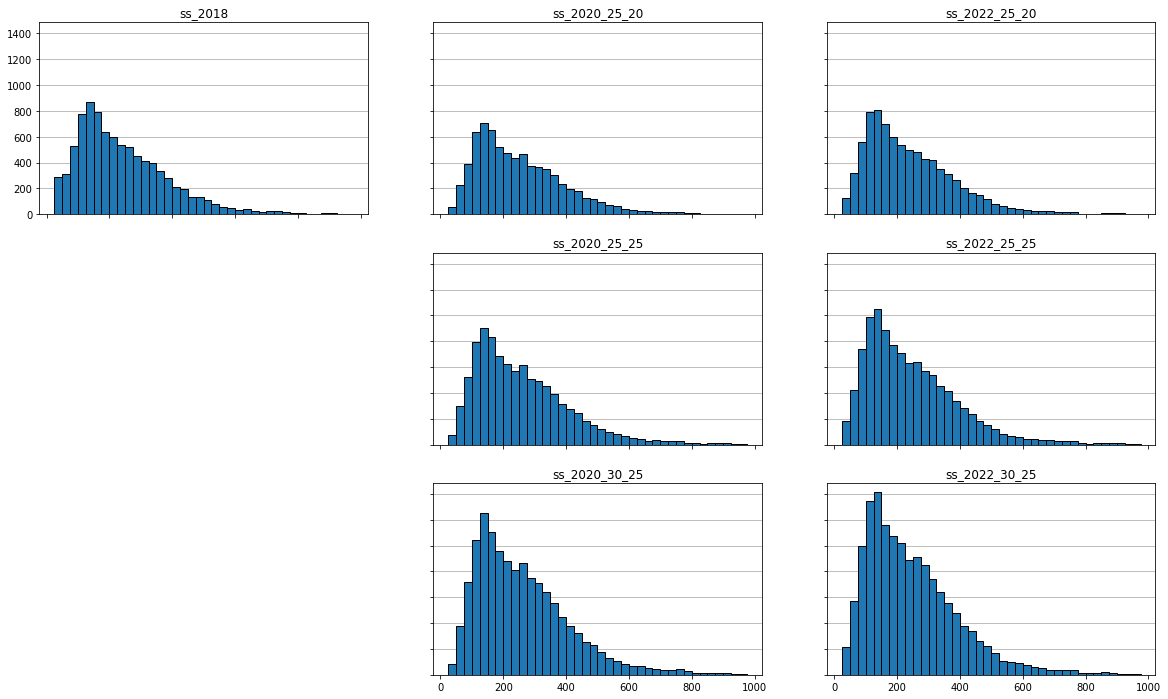

In [131]:
fig, axs = plt.subplots(3, 3, sharex = True, sharey = True, figsize = (20, 12))

bins = range(25, 1000, 25) # bins are truncated at 1000 as there are very few sequences beyond this length

axs[0, 0].hist(ss_2018['len'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[0, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 0].title.set_text('ss_2018')

axs[1, 0].axis('off')
axs[2, 0].axis('off')

axs[0, 1].hist(ss_2020_25_20['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[0, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 1].title.set_text('ss_2020_25_20')

axs[1, 1].hist(ss_2020_25_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[1, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 1].title.set_text('ss_2020_25_25')

axs[2, 1].hist(ss_2020_30_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[2, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 1].title.set_text('ss_2020_30_25')

axs[0, 2].hist(ss_2022_25_20['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[0, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 2].title.set_text('ss_2022_25_20')

axs[1, 2].hist(ss_2022_25_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[1, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 2].title.set_text('ss_2022_25_25')

axs[2, 2].hist(ss_2022_30_25['len_x'], bins = bins, zorder = 3,
                        edgecolor = 'black', linewidth = 1.0)
axs[2, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 2].title.set_text('ss_2022_30_25')

fig.show()

### Secondary Structure Distibutions

The bar plots, below, show the numbers of each secondary structure type for SST-8 and SST-3 categories.  The bars are color coded by their SST-3 groupings in order to illustrate which SST-8 types are collected into SST-3 types.  The one letter abbreviations for SST-8 and SST-3 are:

SST-8 Type | Description | SST-3 Type | Description | Color
--- | --- | --- | --- | ---
B | $\beta$-bridge | E | Sheets | Yellow
E | $\beta$-strand | E | 
G | 3-helix | H | Helices | Red
H | $\alpha$-helix | H |
I | $\pi$-helix | H | 
C | Coil | C | Irregular or extended | Blue
S | Bend | C | 
T | Turn | C |

The largest dataset (2022-12-17-pdb-intersect-pisces_pc30_r2.5.csv) provides nearly 800,000 amino acids in sheets and over 1 million amino acids in helices or irregular strucutres (bends, turns, and coils).

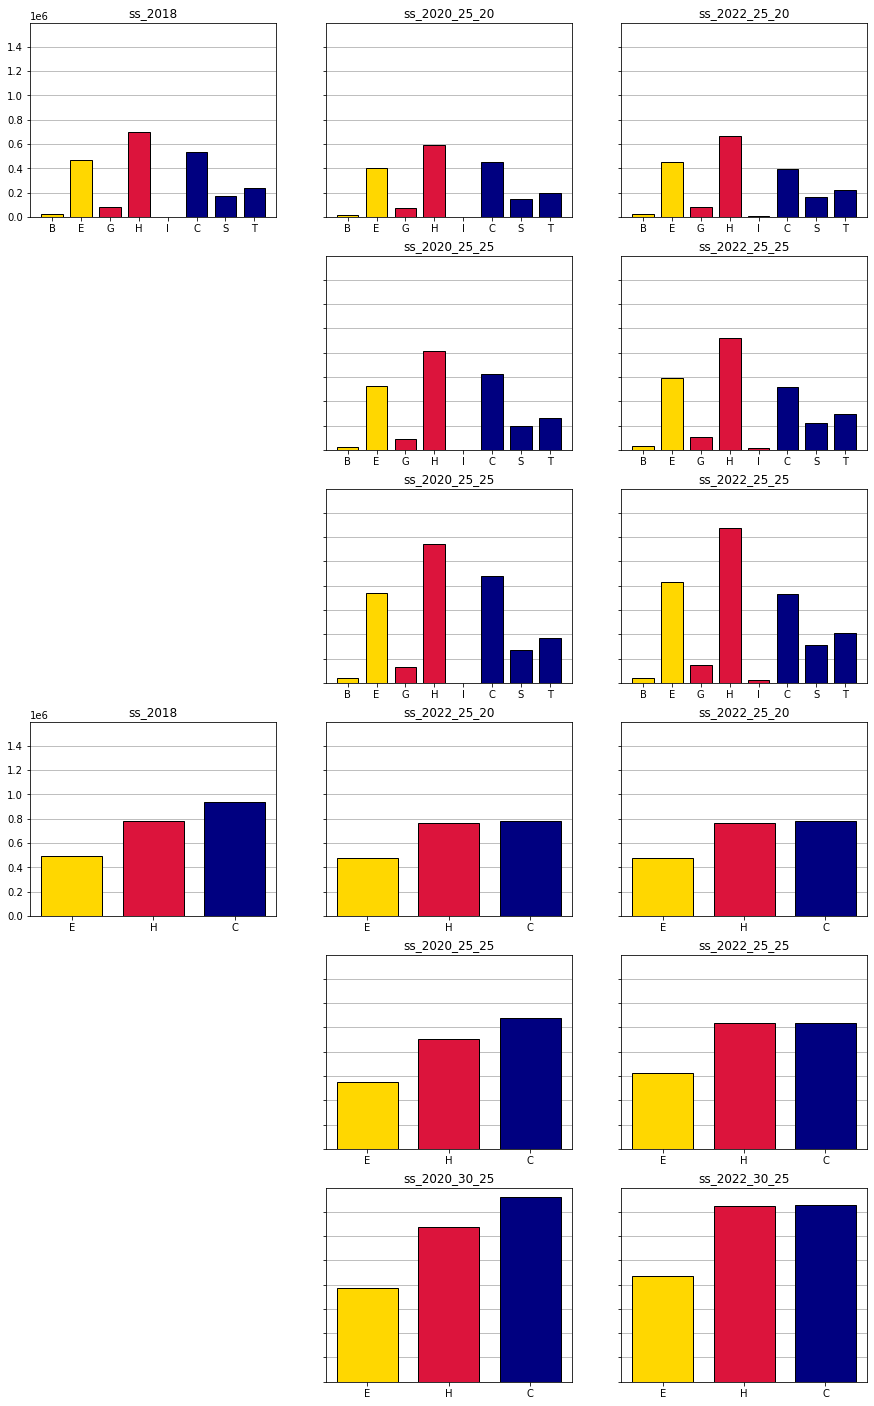

In [132]:
# set up storage for all files, both SST categoreis and the types of SST for each category
SS_counts = {'ss_2018': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2020_25_20': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2020_25_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2020_30_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2022_25_20': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2022_25_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) },
             'ss_2022_30_25': {'SST-8': defaultdict(lambda: 0), 'SST-3': defaultdict(lambda: 0) }}

# count the types for each dataset
for seq in ss_2018['sst8']:
    for ss in set(seq):
        SS_counts['ss_2018']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2018['sst3']:
    for ss in set(seq):
        SS_counts['ss_2018']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2020_25_20['sst8']:
    for ss in set(seq):
        SS_counts['ss_2020_25_20']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2020_25_20['sst3']:
    for ss in set(seq):
        SS_counts['ss_2020_25_20']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2020_25_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2020_25_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2020_25_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2020_25_25']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2020_30_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2020_30_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2020_30_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2020_30_25']['SST-3'][ss] += seq.count(ss)
        
# updated data from end of 2022
for seq in ss_2022_25_20['sst8']:
    for ss in set(seq):
        SS_counts['ss_2022_25_20']['SST-8'][ss] += seq.count(ss)

for seq in ss_2022_25_20['sst3']:
    for ss in set(seq):
        SS_counts['ss_2022_25_20']['SST-3'][ss] += seq.count(ss)
        
for seq in ss_2022_25_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2022_25_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2022_25_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2022_25_25']['SST-3'][ss] += seq.count(ss)
    
for seq in ss_2022_30_25['sst8']:
    for ss in set(seq):
        SS_counts['ss_2022_30_25']['SST-8'][ss] += seq.count(ss)
        
for seq in ss_2022_30_25['sst3']:
    for ss in set(seq):
        SS_counts['ss_2022_30_25']['SST-3'][ss] += seq.count(ss)
        
# plot a comparison across datasets

# define order for ss types
ss8_types = ['B', 'E', 'G', 'H', 'I', 'C', 'S', 'T']
ss3_types = ['E', 'H', 'C']

sst8_colors = ['gold', 'gold', 'crimson', 'crimson', 'crimson', 'navy', 'navy', 'navy']
sst3_colors = ['gold', 'crimson', 'navy']

fig, axs = plt.subplots(6, 3, sharey = 'all', figsize = (15, 25))

# SST-8 comparisons

axs[0, 0].bar(range(8), height = [SS_counts['ss_2018']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 0].title.set_text('ss_2018')

axs[0, 1].bar(range(8), height = [SS_counts['ss_2020_25_20']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 1].title.set_text('ss_2020_25_20')

axs[0, 2].bar(range(8), height = [SS_counts['ss_2022_25_20']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[0, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 2].title.set_text('ss_2022_25_20')

axs[1, 0].axis('off')

axs[1, 1].bar(range(8), height = [SS_counts['ss_2020_25_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[1, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 1].title.set_text('ss_2020_25_25')

axs[1, 2].bar(range(8), height = [SS_counts['ss_2022_25_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[1, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 2].title.set_text('ss_2022_25_25')

axs[2, 0].axis('off')

axs[2, 1].bar(range(8), height = [SS_counts['ss_2020_30_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[2, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 1].title.set_text('ss_2020_25_25')

axs[2, 2].bar(range(8), height = [SS_counts['ss_2022_30_25']['SST-8'][ss] for ss in ss8_types],
              tick_label = ss8_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst8_colors)
axs[2, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 2].title.set_text('ss_2022_25_25')

# SST-3 comparisons

axs[3, 0].bar(range(3), height = [SS_counts['ss_2018']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[3, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[3, 0].title.set_text('ss_2018')

axs[3, 1].bar(range(3), height = [SS_counts['ss_2022_25_20']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[3, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[3, 1].title.set_text('ss_2022_25_20')

axs[3, 2].bar(range(3), height = [SS_counts['ss_2022_25_20']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[3, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[3, 2].title.set_text('ss_2022_25_20')

axs[4, 0].axis('off')

axs[4, 1].bar(range(3), height = [SS_counts['ss_2020_25_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[4, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[4, 1].title.set_text('ss_2020_25_25')

axs[4, 2].bar(range(3), height = [SS_counts['ss_2022_25_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[4, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[4, 2].title.set_text('ss_2022_25_25')

axs[5, 0].axis('off')

axs[5, 1].bar(range(3), height = [SS_counts['ss_2020_30_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[5, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[5, 1].title.set_text('ss_2020_30_25')

axs[5, 2].bar(range(3), height = [SS_counts['ss_2022_30_25']['SST-3'][ss] for ss in ss3_types],
              tick_label = ss3_types, edgecolor = 'black', width = 0.75, zorder = 3, color = sst3_colors)
axs[5, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[5, 2].title.set_text('ss_2022_30_25')

fig.show()

### Amino Acid Representation

Looking at the actual amino acid distributions in the file (ignoring those sequences with non-standard amino acids), the histograms show a similar distribution as those for the secondary structures.  The dataset with similar constraints as the 2018 original loses some content while the datasets with relaxed constraints show substantial increases in actual numbers of amino acids.  Interestingly, the table shows that across all three datasets, the relative proportions of amino acids are very well conserved.

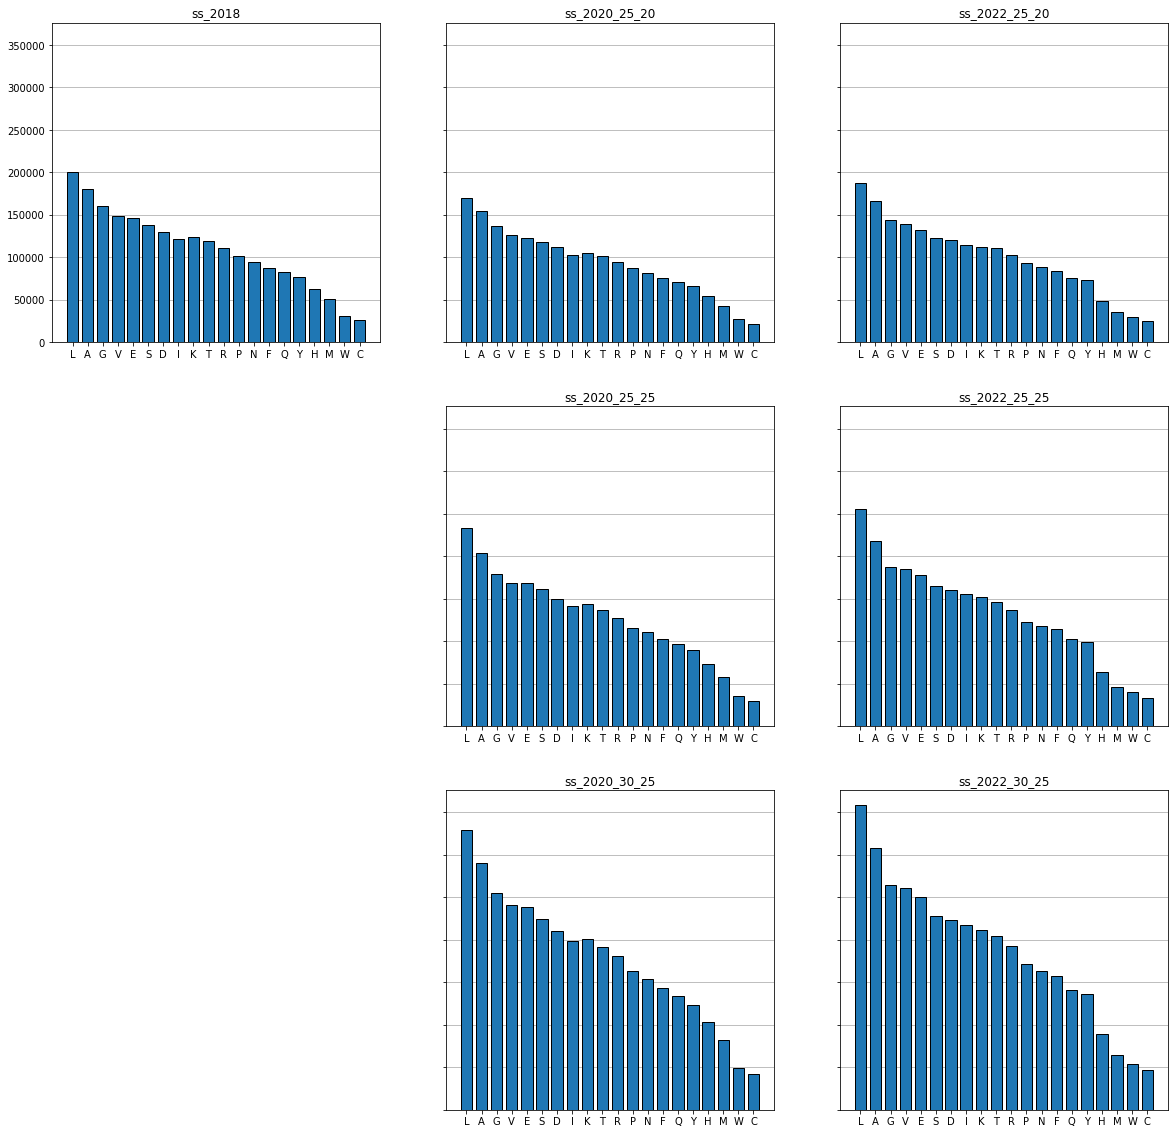

In [133]:
# set up storage for all files
AA_counts = {'ss_2018': defaultdict(lambda: 0),
             'ss_2020_25_20': defaultdict(lambda: 0),
             'ss_2020_25_25': defaultdict(lambda: 0),
             'ss_2020_30_25': defaultdict(lambda: 0),
             'ss_2022_25_20': defaultdict(lambda: 0),
             'ss_2022_25_25': defaultdict(lambda: 0),
             'ss_2022_30_25': defaultdict(lambda: 0)}

# count the types for each dataset
for (seq, nonstd) in zip(ss_2018['seq'], ss_2018['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2018'][aa] += seq.count(aa)

for (seq, nonstd) in zip(ss_2020_25_20['seq'], ss_2020_25_20['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2020_25_20'][aa] += seq.count(aa)

for (seq, nonstd) in zip(ss_2020_25_25['seq'], ss_2020_25_25['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2020_25_25'][aa] += seq.count(aa)
            
for (seq, nonstd) in zip(ss_2020_30_25['seq'], ss_2020_30_25['has_nonstd_aa']):
    if not nonstd:
        try:
            for aa in set(seq):
                if aa != '*':
                    AA_counts['ss_2020_30_25'][aa] += seq.count(aa)
        except:
            pass
                
for (seq, nonstd) in zip(ss_2022_25_20['seq'], ss_2022_25_20['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2022_25_20'][aa] += seq.count(aa)

for (seq, nonstd) in zip(ss_2022_25_25['seq'], ss_2022_25_25['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2022_25_25'][aa] += seq.count(aa)
            
for (seq, nonstd) in zip(ss_2022_30_25['seq'], ss_2022_30_25['has_nonstd_aa']):
    if not nonstd:
        for aa in set(seq):
            if aa != '*':
                AA_counts['ss_2022_30_25'][aa] += seq.count(aa)
            
[sum(AA_counts[d].values()) for d in AA_counts.keys()]

# order the amino acids by decreasing total abundance
total_aa = [sum([AA_counts[d][aa] for d in AA_counts.keys()]) for aa in AA_counts['ss_2018'].keys() ]
temp = sorted(total_aa, reverse = True)    
order = [total_aa.index(v) for v in temp]
aa_order = [list(AA_counts['ss_2018'].keys())[i] for i in order]

# plot a comparison across datasets
fig, axs = plt.subplots(3, 3, sharey = True, figsize = (20, 20))

axs[0, 0].bar(range(20), height = [AA_counts['ss_2018'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[0, 0].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 0].title.set_text('ss_2018')

axs[0, 1].bar(range(20), height = [AA_counts['ss_2020_25_20'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[0, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 1].title.set_text('ss_2020_25_20')

axs[0, 2].bar(range(20), height = [AA_counts['ss_2022_25_20'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[0, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[0, 2].title.set_text('ss_2022_25_20')

axs[1, 0].axis('off')

axs[1, 1].bar(range(20), height = [AA_counts['ss_2020_25_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[1, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 1].title.set_text('ss_2020_25_25')

axs[1, 2].bar(range(20), height = [AA_counts['ss_2022_25_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[1, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[1, 2].title.set_text('ss_2022_25_25')

axs[2, 0].axis('off')

axs[2, 1].bar(range(20), height = [AA_counts['ss_2020_30_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[2, 1].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 1].title.set_text('ss_2020_30_25')

axs[2, 2].bar(range(20), height = [AA_counts['ss_2022_30_25'][aa] for aa in aa_order],
              tick_label = aa_order, edgecolor = 'black', width = 0.75, zorder = 3)
axs[2, 2].grid(axis = 'y', which = 'both', zorder = 0)
axs[2, 2].title.set_text('ss_2022_30_25')

fig.show()

In [134]:
# show proportion of each amino acid in a table
tbl_data = {'Amino Acid': aa_order,
            'ss_2018': [ round(AA_counts['ss_2018'][aa] / sum(AA_counts['ss_2018'].values()), 3) for aa in aa_order],
            'ss_2020_25_20': [ round(AA_counts['ss_2020_25_20'][aa] / sum(AA_counts['ss_2020_25_20'].values()), 3) for aa in aa_order],
            'ss_2020_25_25': [ round(AA_counts['ss_2020_25_25'][aa] / sum(AA_counts['ss_2020_25_25'].values()), 3) for aa in aa_order],
            'ss_2020_30_25': [ round(AA_counts['ss_2020_30_25'][aa] / sum(AA_counts['ss_2020_30_25'].values()), 3) for aa in aa_order],
            'ss_2022_25_20': [ round(AA_counts['ss_2022_25_20'][aa] / sum(AA_counts['ss_2022_25_20'].values()), 3) for aa in aa_order],
            'ss_2022_25_25': [ round(AA_counts['ss_2022_25_25'][aa] / sum(AA_counts['ss_2022_25_25'].values()), 3) for aa in aa_order],
            'ss_2022_30_25': [ round(AA_counts['ss_2022_30_25'][aa] / sum(AA_counts['ss_2022_30_25'].values()), 3) for aa in aa_order]}
pd.DataFrame(tbl_data)

,Amino Acid,ss_2018,ss_2020_25_20,ss_2020_25_25,ss_2020_30_25,ss_2022_25_20,ss_2022_25_25,ss_2022_30_25
0,L,0.091,0.091,0.092,0.093,0.093,0.095,0.095
1,A,0.082,0.083,0.081,0.082,0.083,0.081,0.082
2,G,0.073,0.073,0.071,0.072,0.072,0.069,0.070
3,V,0.068,0.068,0.067,0.068,0.069,0.069,0.069
4,E,0.067,0.066,0.067,0.067,0.066,0.066,0.066
5,S,0.063,0.063,0.064,0.063,0.061,0.061,0.061
6,D,0.059,0.060,0.059,0.059,0.060,0.059,0.059
7,I,0.055,0.055,0.056,0.056,0.057,0.058,0.058
8,K,0.056,0.056,0.057,0.057,0.056,0.056,0.056
9,T,0.054,0.055,0.054,0.054,0.055,0.054,0.054


In [135]:
# Cell 5: Custom Dataset Class with GPU Support
class ProteinDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
        
        # Create amino acid and structure mappings
        self.aa_to_idx = {aa: idx for idx, aa in enumerate('ACDEFGHIKLMNPQRSTVWY')}
        self.struct_to_idx = {'H': 0, 'E': 1, 'C': 2}
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        
        # Convert sequence to numerical form (on CPU)
        seq_tensor = torch.zeros(len(seq), len(self.aa_to_idx))
        for i, aa in enumerate(seq):
            if aa in self.aa_to_idx:
                seq_tensor[i, self.aa_to_idx[aa]] = 1
                
        # Convert structure to numerical form (on CPU)
        label_tensor = torch.tensor([self.struct_to_idx[s] for s in label])
        
        return seq_tensor, label_tensor

In [136]:
def collate_fn(batch):
    # Separate sequences and labels
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Pad sequences to the same length
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)  # -1 for padding
    
    return sequences_padded, labels_padded
    
    # Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True  # This helps with CUDA transfer
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

In [137]:
# Cell 6: Data Preparation with GPU Support
# Filter and split data
data = ss_2018[~ss_2018['has_nonstd_aa']]
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.125, random_state=42)

# Create datasets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = ProteinDataset(train_data['seq'].values, train_data['sst3'].values, device)
val_dataset = ProteinDataset(val_data['seq'].values, val_data['sst3'].values, device)
test_dataset = ProteinDataset(test_data['seq'].values, test_data['sst3'].values, device)

# Create dataloaders with pin_memory for faster GPU transfer
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, pin_memory=True)

# Clear memory
del data, train_data, test_data, val_data
gc.collect()
torch.cuda.empty_cache()

TypeError: __init__() takes 3 positional arguments but 4 were given

In [ ]:
class CNNBiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.1):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout)
        )
        
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_classes)
        )
    
    def forward(self, x, lengths=None):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size, seq_len, _ = x.size()
        
        # CNN expects (batch_size, input_dim, seq_len)
        x = x.transpose(1, 2)
        x = self.cnn(x)
        
        # LSTM expects (batch_size, seq_len, hidden_dim)
        x = x.transpose(1, 2)
        
        if lengths is not None:
            # Pack the padded sequence
            packed_x = pack_padded_sequence(x, lengths.cpu(), 
                                         batch_first=True, 
                                         enforce_sorted=False)
            packed_output, (hidden, _) = self.lstm(packed_x)
            # Unpack the sequence
            output, _ = pad_packed_sequence(packed_output, batch_first=True)
        else:
            output, (hidden, _) = self.lstm(x)
        
        # Use the last hidden state from both directions
        hidden_final = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.fc(hidden_final)
        
        return output

In [ ]:
# Cell 8: Transformer Model with GPU Optimization
class TransformerModel(nn.Module):
    def __init__(self, input_size=20, hidden_size=256, num_classes=3, num_heads=8):
        super().__init__()
        
        self.embedding = nn.Linear(input_size, hidden_size)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=hidden_size*4,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_classes)
        )
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x

In [ ]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.criterion = nn.CrossEntropyLoss(ignore_index=-1)  # Ignore padding
        self.optimizer = optim.Adam(model.parameters())
    
    def train_epoch(self):
        self.model.train()
        total_loss = 0
        
        for sequences, labels in self.train_loader:
            # Move data to device here
            sequences = sequences.to(self.device)
            labels = labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(sequences)
            
            # Reshape for CrossEntropyLoss
            batch_size, seq_len, num_classes = outputs.shape
            outputs = outputs.view(-1, num_classes)
            labels = labels.view(-1)
            
            # Calculate loss
            loss = self.criterion(outputs, labels)
            
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for sequences, labels in self.val_loader:
                sequences = sequences.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(sequences)
                
                # Reshape for loss calculation
                batch_size, seq_len, num_classes = outputs.shape
                outputs = outputs.view(-1, num_classes)
                labels = labels.view(-1)
                
                loss = self.criterion(outputs, labels)
                
                # Calculate accuracy (ignoring padding)
                mask = (labels != -1)
                _, predicted = outputs.max(1)
                total += mask.sum().item()
                correct += ((predicted == labels) & mask).sum().item()
                
                total_loss += loss.item()
        
        accuracy = correct / total if total > 0 else 0
        return total_loss / len(self.val_loader), accuracy

In [ ]:
# Cell 10: Training Pipeline
def train_model(model_class, train_loader, val_loader, device, num_epochs=30):
    # Define model parameters
    input_dim = 20  # Match your input feature dimension
    hidden_dim = 64  # You can adjust this
    num_classes = 2  # Match your number of classes
    
    # Initialize model with parameters
    model = model_class(
        input_dim=input_dim,
        hidden_dim=hidden_dim,
        num_classes=num_classes,
        num_layers=2,
        dropout=0.2
    ).to(device)
    
    trainer = Trainer(model, train_loader, val_loader, device)
    
    # Store training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': []
    }
    
    for epoch in range(num_epochs):
        # Training
        train_loss = trainer.train_epoch()
        
        # Validation
        val_loss, val_accuracy = trainer.validate()
        
        # Store metrics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_accuracy)
        
        # Print progress
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}')
        print(f'Val Loss: {val_loss:.4f}')
        print(f'Val Accuracy: {val_accuracy:.4f}')
        
    return history

# Then you can call it as before
cnn_lstm_history = train_model(CNNBiLSTMModel, train_loader, val_loader, device)

In [ ]:
# Cell 11: Model Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train CNN+BiLSTM model
print("\nTraining CNN+BiLSTM model...")
cnn_lstm_history = train_model(CNNBiLSTMModel, train_loader, val_loader, device)

# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()

# Train Transformer model
print("\nTraining Transformer model...")
transformer_history = train_model(TransformerModel, train_loader, val_loader, device)